# Tarea 2

In [407]:
#manejo de datos
import pandas as pd
import numpy as np

#gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


#creación de modelos
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier


#pruebas paramétricas
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu



#prevenir warnings
import warnings


# Calculo de medidas de tendencia central y dispersión

In [439]:
#Creación de funciones para calcular medidas de tendencia central y dispersión

def media(numeros):
    return sum(numeros) / len(numeros)

def varianza_m(numeros):
    media = sum(numeros) / len(numeros)
    return sum( (x - media) ** 2 for x in numeros) / (len(numeros)-1)



#probamos las funciones creadas

print(
    f"La media de la columna 'loan_amnt' es: {media(loan_data['loan_amnt'])}" 
    f"\nLa varianza de la columna 'loan_amnt' es: {varianza_m(loan_data['loan_amnt'])} "
    )	


La media de la columna 'loan_amnt' es: 15235.487885986884
La varianza de la columna 'loan_amnt' es: 73432898.08331825 


In [440]:
#Calculamos la media y varianza de todas las columnas numéricas

# Lista para almacenar los resultados
resultados = []


for col in loan_data.select_dtypes('number').columns:
    # Omitir los valores NaN en la columna actual
    columna_sin_na = loan_data[col].dropna()
    
    media_col = media(columna_sin_na)
    varianza_col = varianza_m(columna_sin_na)
    
    resultados.append([col, media_col, varianza_col])


# Convertir la lista de resultados en un DataFrame
df_resultados = pd.DataFrame(resultados, columns=['columna', 'media', 'varianza'])

# Mostrar el DataFrame
print(df_resultados)

                          columna         media           varianza
0                       loan_amnt  15235.487886    73432898.083318
1                     funded_amnt  15235.487886    73432898.083318
2                 funded_amnt_inv  15229.360961    73374862.450680
3                            term     43.855421         126.822771
4                        int_rate     12.584844          18.598200
5                     installment    441.629698       59885.716338
6                      emp_length      2.324053           8.230321
7                      annual_inc  76956.015218  5294690726.126194
8                             dti     19.189201         555.957077
9                     delinq_2yrs      0.346032           0.856914
10                 inq_last_6mths      0.571523           0.751151
11         mths_since_last_delinq     17.597176         537.785533
12                       open_acc     11.950089          31.732438
13                        pub_rec      0.233680           0.42

# Prueba de normalidad

In [441]:
#Comprobación si las variables numéricas siguen una distribución normal (paramétricas)

#usamos un α = 0.05 para determinar si la variable sigue una distribución normal

# Lista para almacenar los resultados
resultados = []


for col in loan_data.select_dtypes('number').columns:
    # Omitir los valores NaN en la columna actual
    columna_sin_na = loan_data[col].dropna()
    pvalor=shapiro(columna_sin_na)[1]
    if shapiro(columna_sin_na)[1] < 0.05:
        texto = 'No sigue una distribución normal'
    else:
        texto = 'Sigue una distribución normal'
    
    resultados.append([col, pvalor,texto])
    
    
resultados= pd.DataFrame(resultados, columns=['columna', 'pvalor','Distribución'])

print(resultados)



#Se concluye que ninguna variable numérica sigue una distribución normal



                          columna   pvalor                      Distribución
0                       loan_amnt 0.000000  No sigue una distribución normal
1                     funded_amnt 0.000000  No sigue una distribución normal
2                 funded_amnt_inv 0.000000  No sigue una distribución normal
3                            term 0.000000  No sigue una distribución normal
4                        int_rate 0.000000  No sigue una distribución normal
5                     installment 0.000000  No sigue una distribución normal
6                      emp_length 0.000000  No sigue una distribución normal
7                      annual_inc 0.000000  No sigue una distribución normal
8                             dti 0.000000  No sigue una distribución normal
9                     delinq_2yrs 0.000000  No sigue una distribución normal
10                 inq_last_6mths 0.000000  No sigue una distribución normal
11         mths_since_last_delinq 0.000000  No sigue una distribución normal

# Gráficos de distribución de las variables numéricas

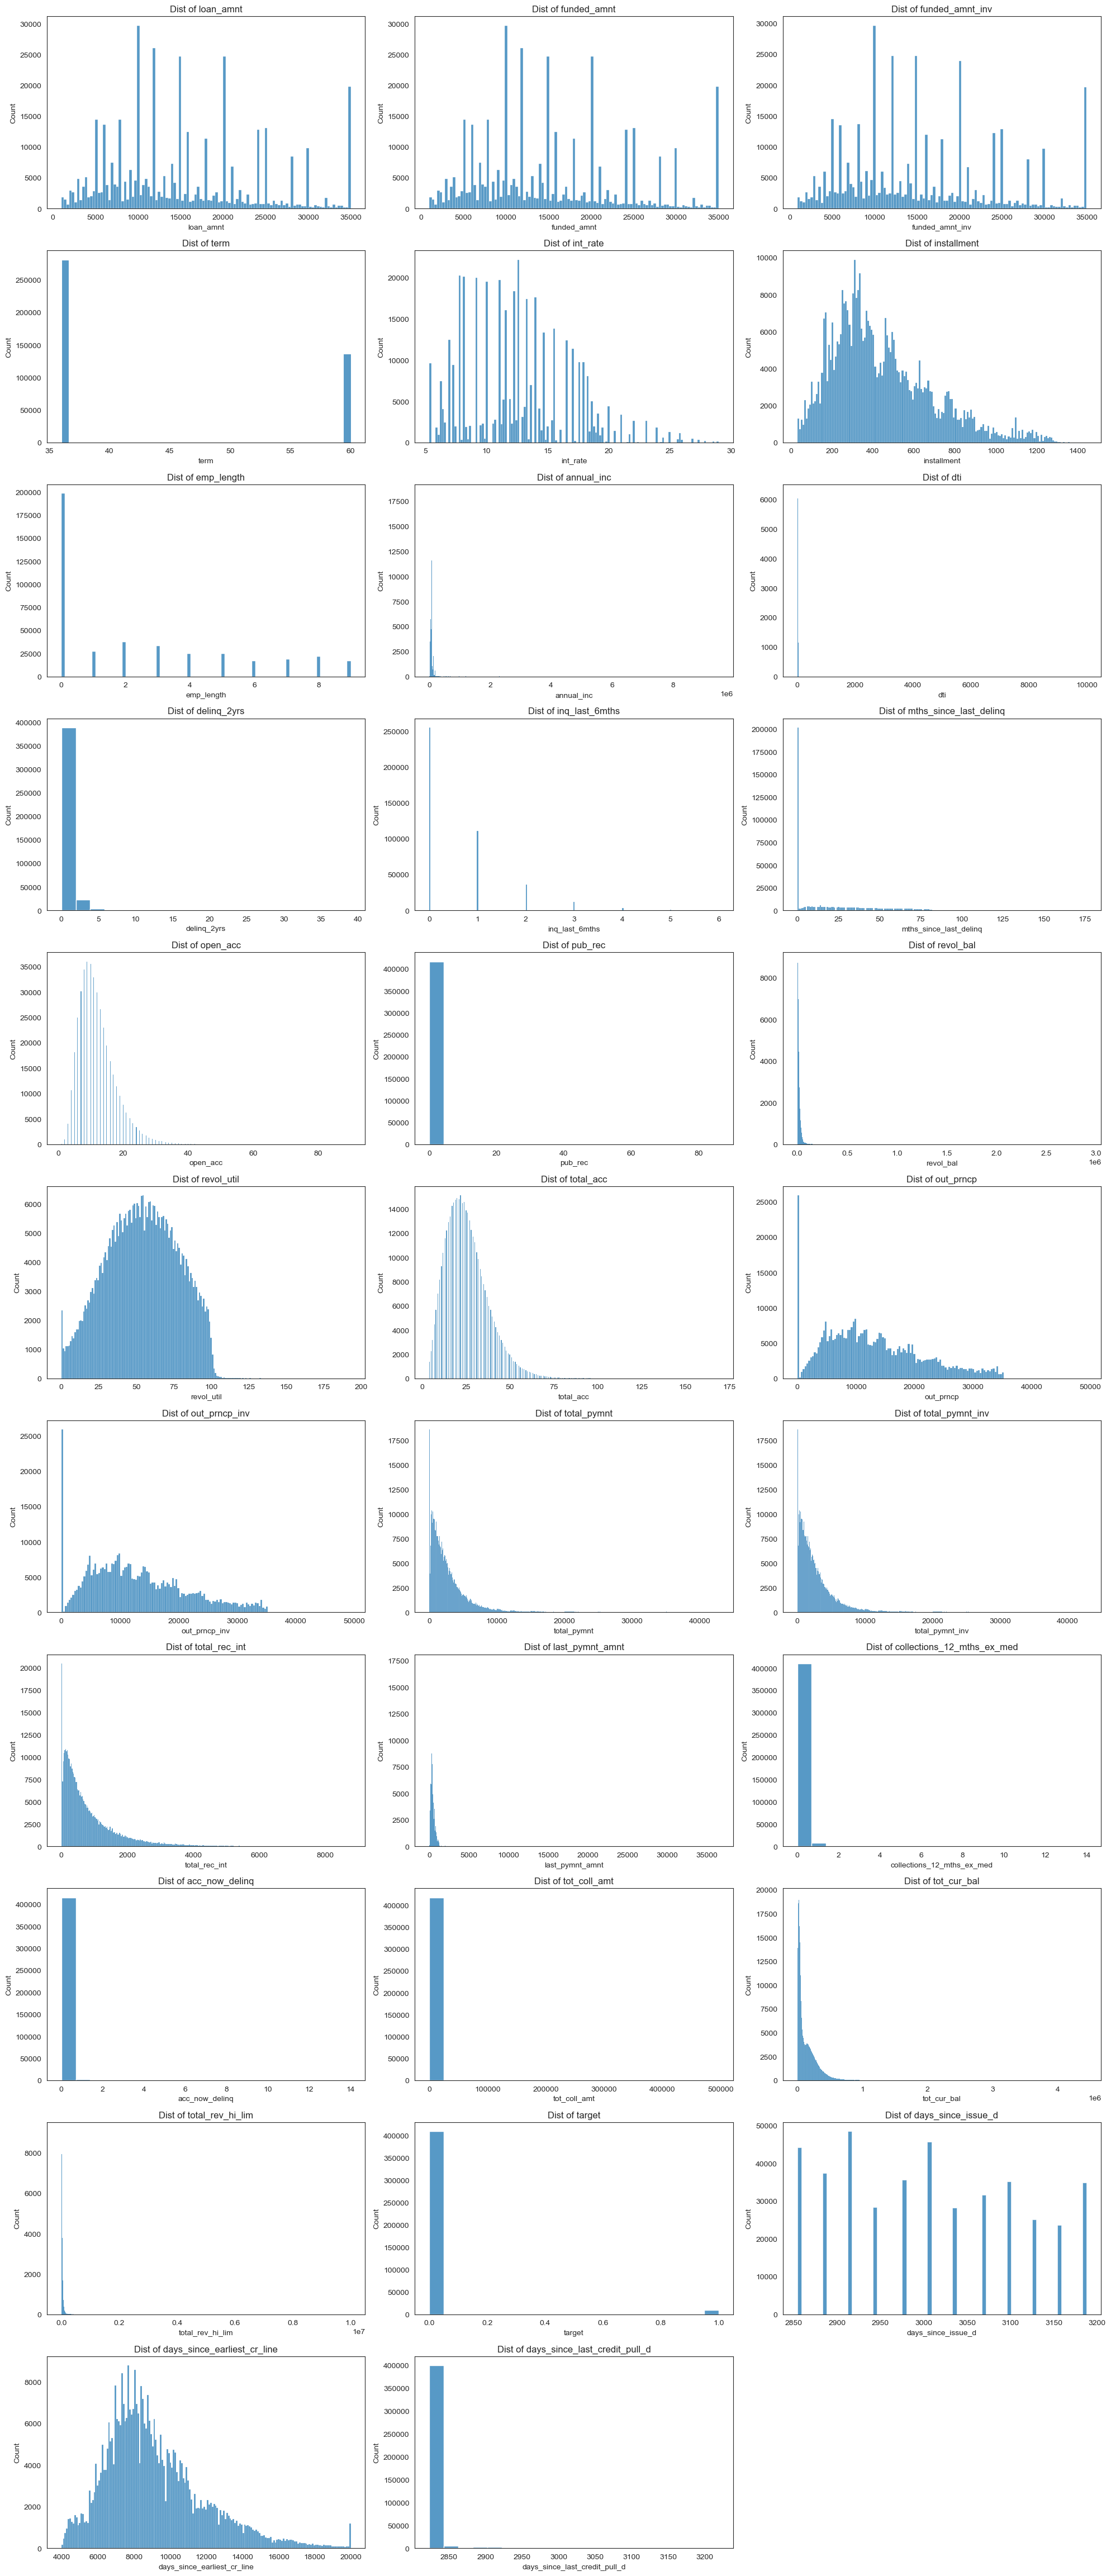

In [442]:
#Distribución de las variables

num_cols = loan_data.select_dtypes('number').columns

plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.histplot(data=loan_data, x=num_cols[i])
    plt.title(f'Dist of {num_cols[i]}')


plt.tight_layout();

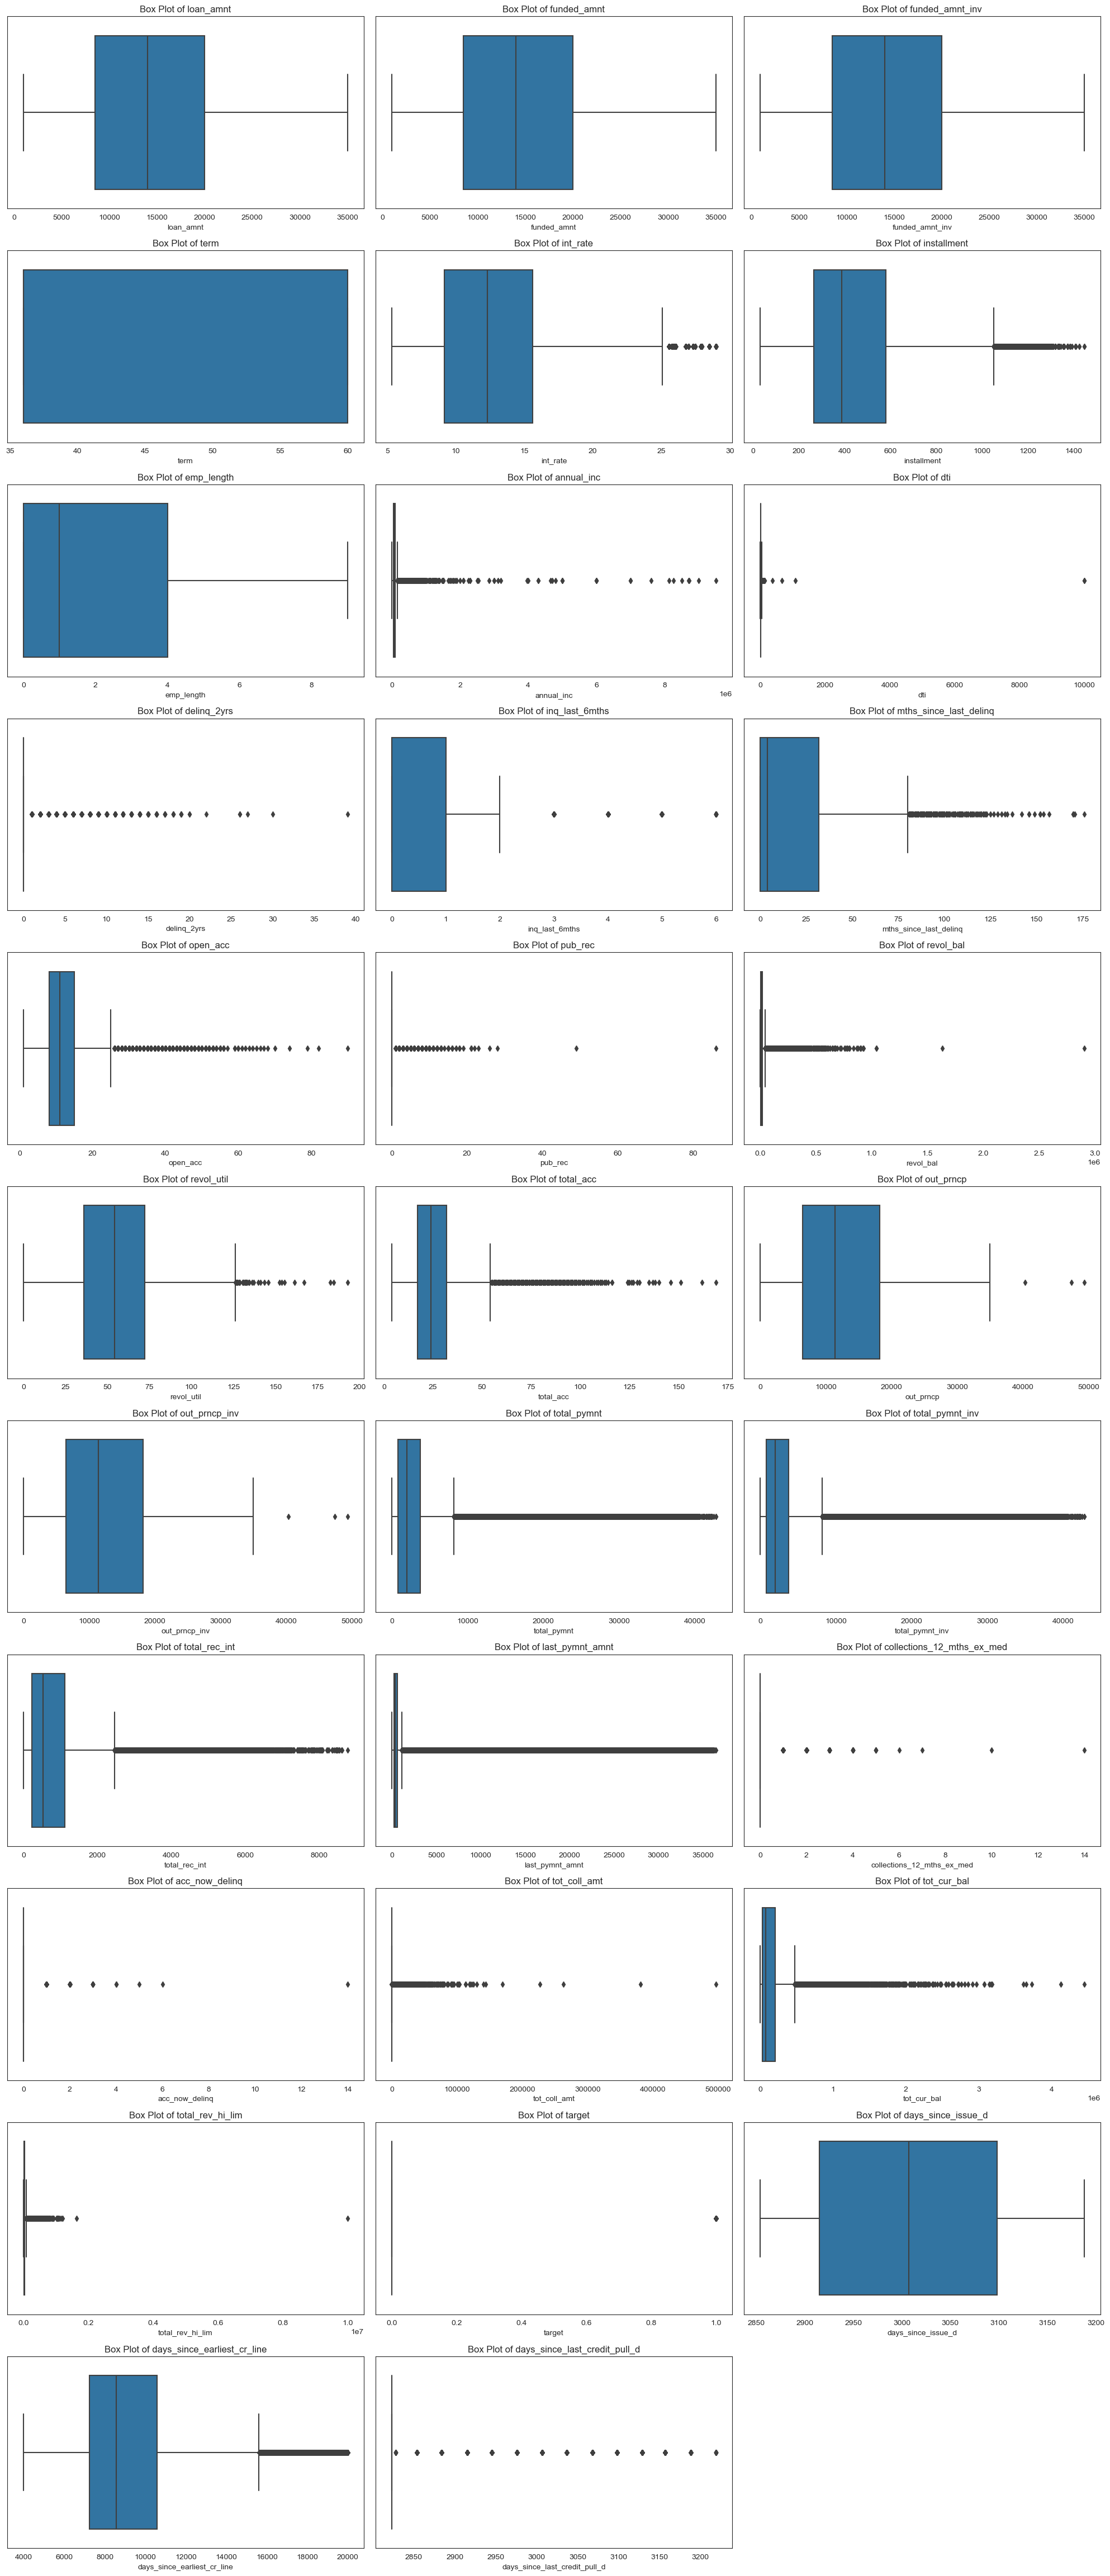

In [443]:
#Boxplot de las variables
num_cols = loan_data.select_dtypes('number').columns

plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(data=loan_data, x=num_cols[i])
    plt.title(f'Box Plot of {num_cols[i]}')


plt.tight_layout();

# Matriz de correlaciones variables numéricas

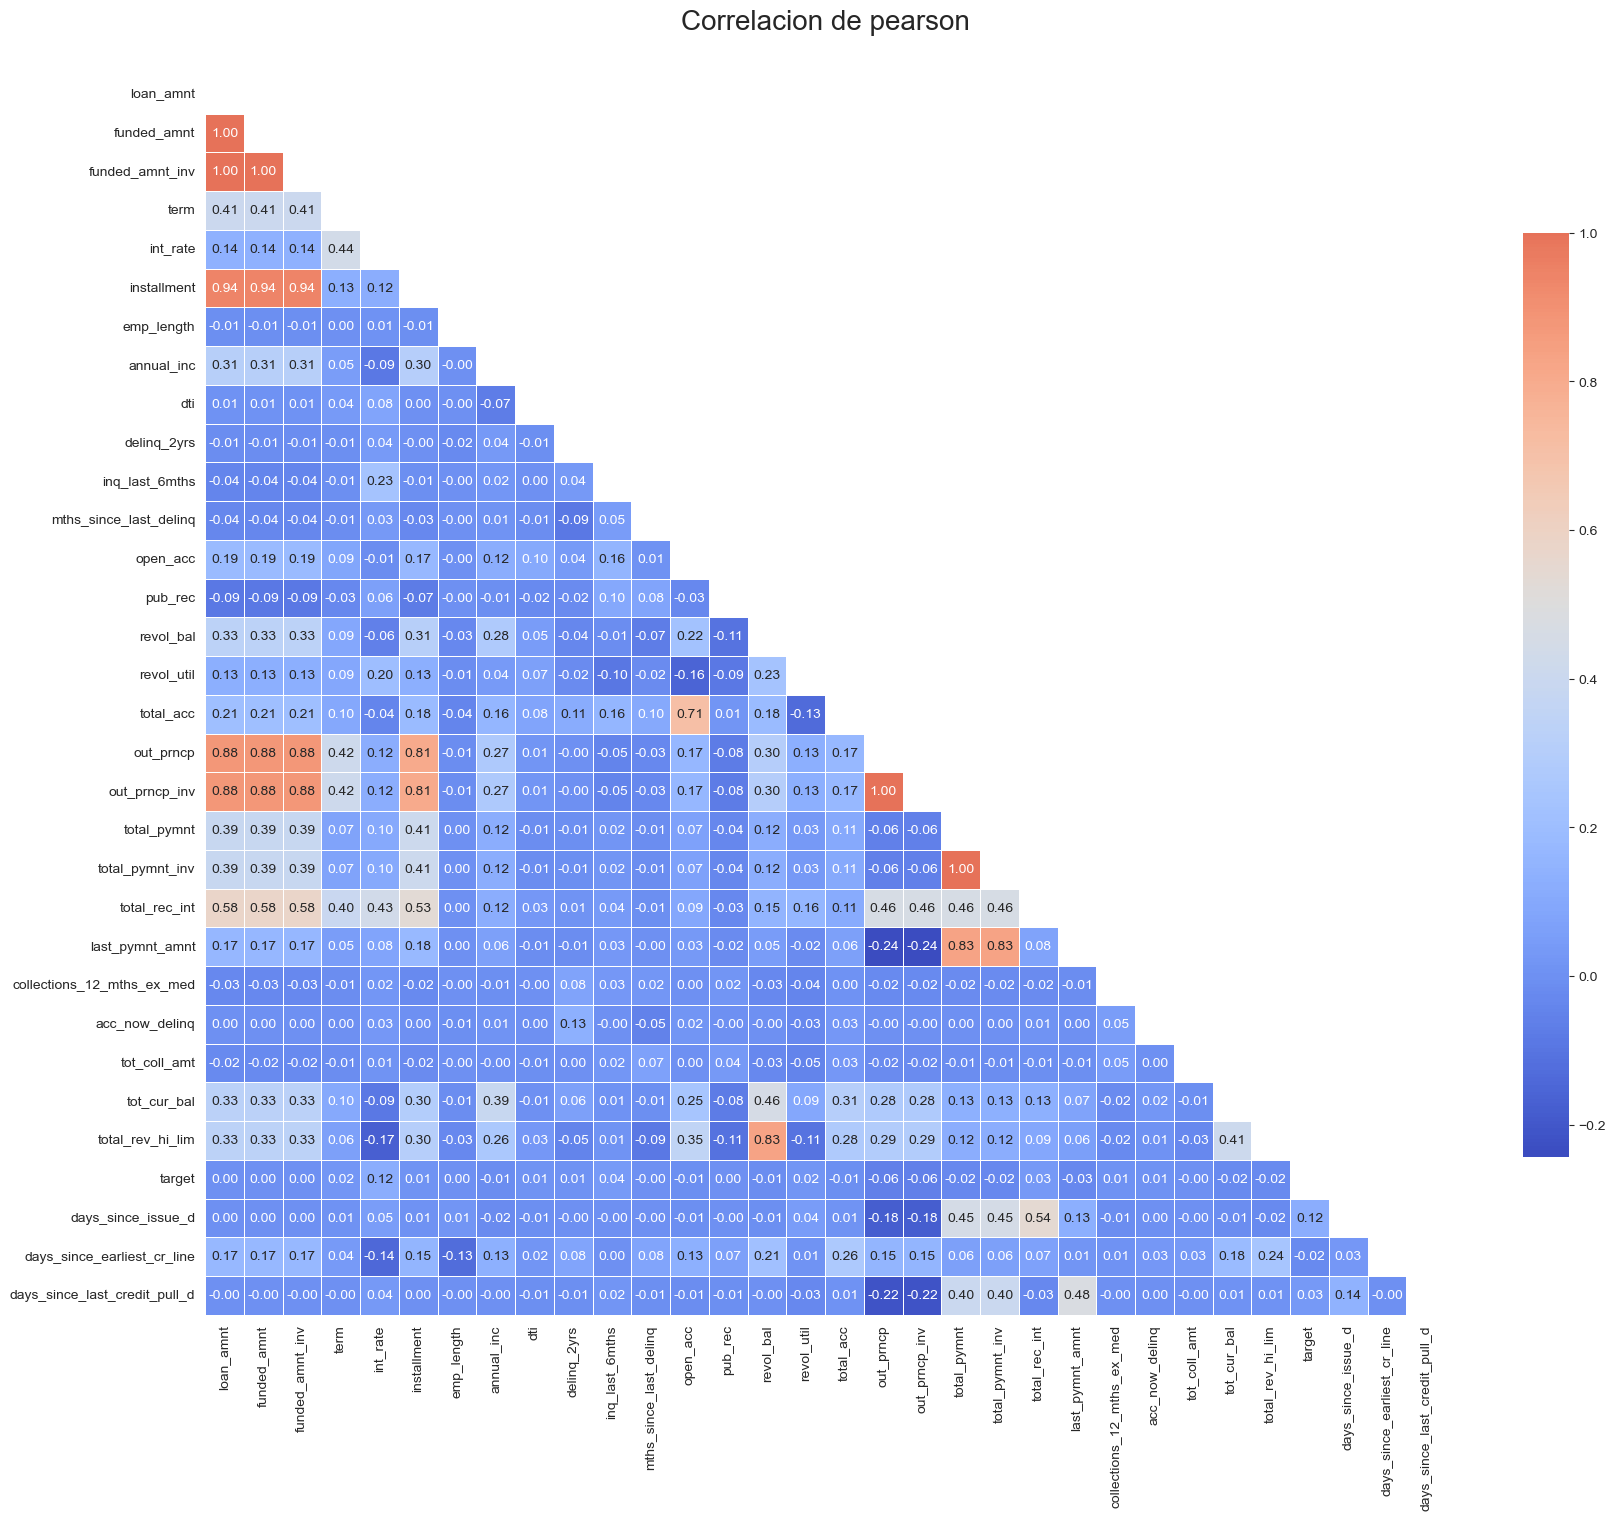

"\nObservamos que las variables 'funded_amnt' , 'loan_amnt' y 'found_amnt_inv' tienen  el mismo comportamiento.\nal igual que las variables out_prncp y out_prncp_inv\nPor lo que vamos a realizar una prueba de hipótesis para determinar si son iguales\n"

In [444]:

# calcula la correlación de Pearson entre las variables numéricas sin NA
corrmat = loan_data.select_dtypes('number').dropna().corr(method='pearson')

# Función para solo dejar una mitad de la matriz, ya que es simétrica
mask = np.triu(np.ones_like(corrmat, dtype=np.bool_))

# Inicializa la figura
f, ax = plt.subplots(figsize=(20, 20))

# Define ña paleta de color
cmap = sns.color_palette("RdBu_r", as_cmap=True)

# Crea el mapa de calor con la matriz de correlación
sns.heatmap(corrmat, cmap='coolwarm', mask=mask, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True, fmt=".2f",
            annot_kws={"size": 10})

# Ajustamos el titulo
ax.set_title("Correlacion de pearson", fontsize=20, y=1.03)

# Show the plot
plt.show()

'''
Observamos que las variables 'funded_amnt' , 'loan_amnt' y 'found_amnt_inv' tienen  el mismo comportamiento.
al igual que las variables out_prncp y out_prncp_inv
Por lo que vamos a realizar una prueba de hipótesis para determinar si son iguales
'''

# Prueba de hipótesis

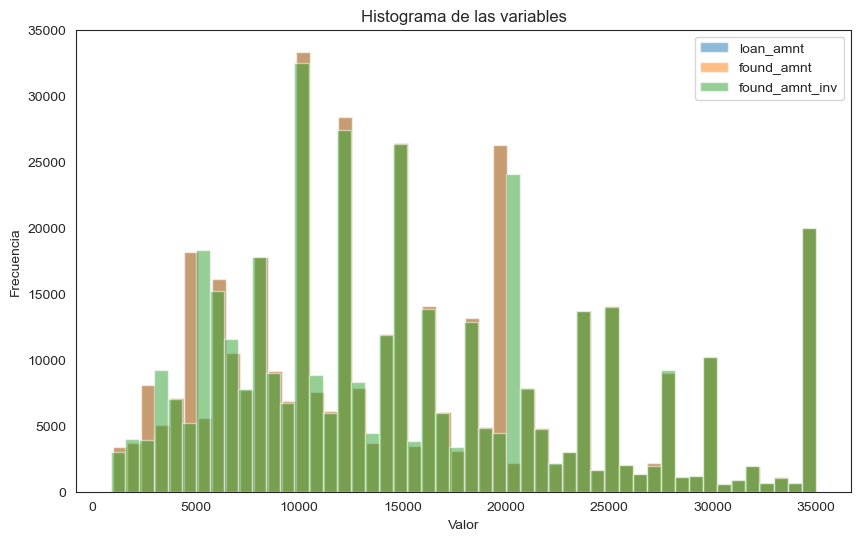

Estadístico: 87356566084.5
Valor p: 1.0
Estadístico: 87530864561.0
Valor p: 0.11393811787279425


In [445]:
# Realizar la prueba  Mann-Whitney U, para determinar si las distribuciones de las variables son iguales

#H0 (Hipótesis nula): Las distribuciones de ambas muestras son iguales, por lo que no hay diferencia entre las dos poblaciones de las que se extrajeron las muestras.

#H1 (Hipótesis alternativa): Las distribuciones de las muestras son diferentes.

#usamos α = 0.05 para determinar si las distribuciones son iguales
statistic1, p_value1 = mannwhitneyu(loan_data['loan_amnt'], loan_data['funded_amnt'])
statistic2, p_value2 = mannwhitneyu(loan_data['loan_amnt'], loan_data['funded_amnt_inv'])


# Visualizar las distribuciones
plt.figure(figsize=(10, 6))
plt.hist(loan_data['loan_amnt'], bins=50, alpha=0.5, label='loan_amnt')
plt.hist(loan_data['funded_amnt'], bins=50, alpha=0.5, label='found_amnt')
plt.hist(loan_data['funded_amnt_inv'], bins=50, alpha=0.5, label='found_amnt_inv')
plt.legend()
plt.title('Histograma de las variables')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

print(f"Estadístico: {statistic1}")
print(f"Valor p: {p_value1}")

print(f"Estadístico: {statistic2}")
print(f"Valor p: {p_value2}")



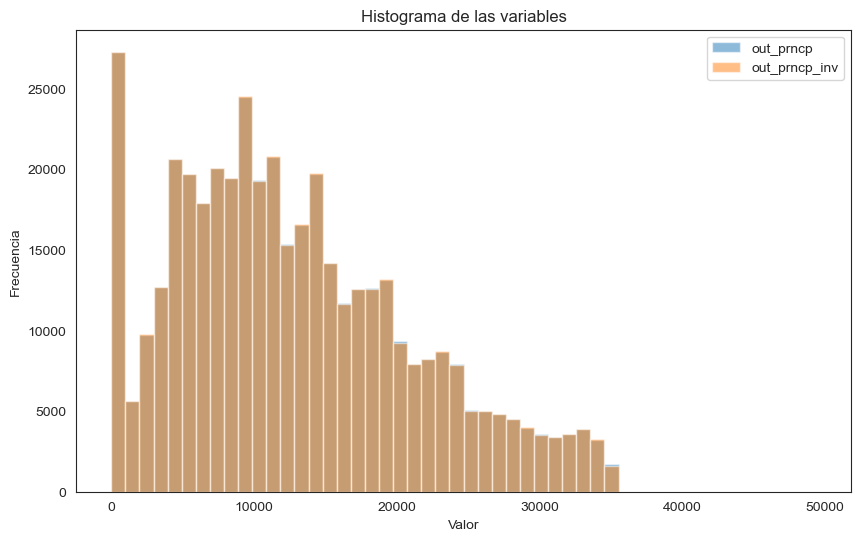

Estadístico: 87386096536.0
Valor p: 0.7889283707540293


In [446]:
# Realizar la prueba  Mann-Whitney U, para determinar si las distribuciones de las variables son iguales

#H0 (Hipótesis nula): Las distribuciones de ambas muestras son iguales, por lo que no hay diferencia entre las dos poblaciones de las que se extrajeron las muestras.

#H1 (Hipótesis alternativa): Las distribuciones de las muestras son diferentes.

#usamos α = 0.05 para determinar si las distribuciones son iguales
statistic3, p_value3 = mannwhitneyu(loan_data['out_prncp'], loan_data['out_prncp_inv'])



# Visualizar las distribuciones
plt.figure(figsize=(10, 6))
plt.hist(loan_data['out_prncp'], bins=50, alpha=0.5, label='out_prncp')
plt.hist(loan_data['out_prncp_inv'], bins=50, alpha=0.5, label='out_prncp_inv')
plt.legend()
plt.title('Histograma de las variables')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.show()

print(f"Estadístico: {statistic3}")
print(f"Valor p: {p_value3}")



In [447]:
'''
Se concluye que las distribuciones de las variables 'founded_amnt' y 'funded_amnt_inv' son iguales a la de loan_ammt, por lo que eliminamos la variable 'funded_amnt' y 'funded_amnt_inv'
De igual manera las distribuciones de las variables 'out_prncp' y 'out_prncp_inv' son iguales, por lo que eliminamos la variable 'out_prncp_inv'
'''

loan_data.drop(columns = ['funded_amnt', 'funded_amnt_inv', 'out_prncp_inv'], inplace = True)

# Matriz de correlaciones variables categóricas

In [448]:

'''
La V de Cramer es una medida de asociación entre dos variables categóricas.
Proporciona un valor entre 0 y 1 que indica la fuerza de la relación entre las variables.
Es una extensión del coeficiente de contingencia y se basa en la estadística chi-cuadrado


vamos a definir la siguiente tabla de interpretación de la V de Cramer

[0,0.1) : No hay correlación
[0.1,0.3) : Correlación débil
[0.3,0.5) : Correlación moderada
[0.5,1] : Correlación fuerte
'''
#Función para calcular el coeficiente de correlación de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

#Función para crear la matriz de correlación de Cramer
def categorical_corr_matrix(df):
    # Seleccionar solo columnas categóricas
    cat_cols = df.select_dtypes(exclude=[np.number]).columns
    n = len(cat_cols)
    corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=cat_cols, index=cat_cols)
    for col1 in cat_cols:
        for col2 in cat_cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
            else:
                corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])
    return corr_matrix

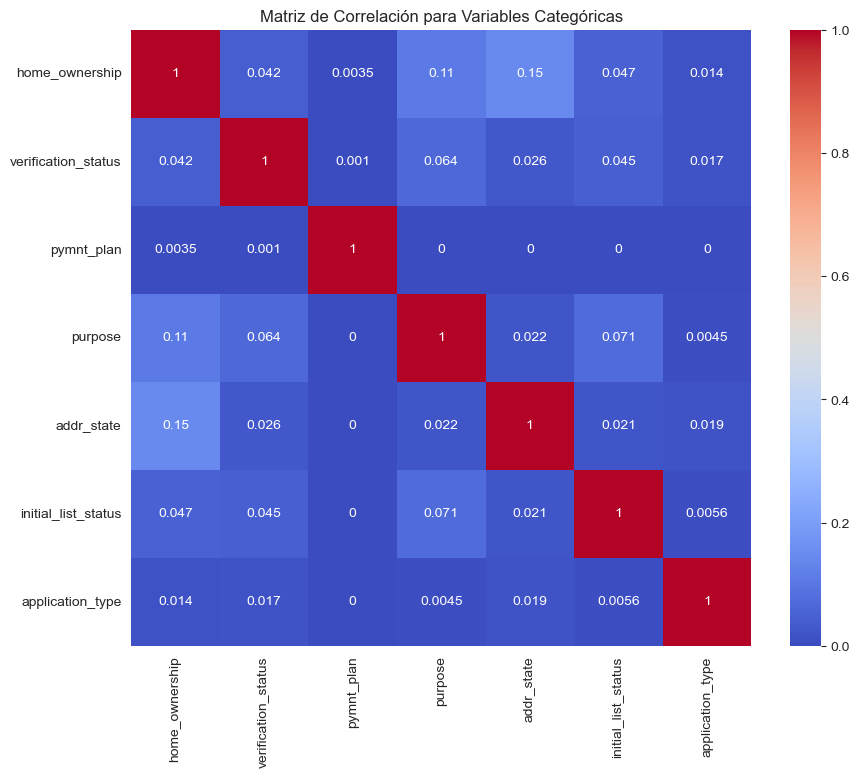

In [449]:
#hacemos el calculo y lo mostramos

corr_matrix = categorical_corr_matrix(loan_data)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Matriz de Correlación para Variables Categóricas')
plt.show()

# Verificamos la importancia de cada variable respecto a la objetivo

In [450]:
#para variables categóricas

#H0 (Hipótesis nula): No hay asociación entre las dos variables categóricas. Es decir, las variables son independientes entre sí.

#H1 (Hipótesis alternativa): Existe una asociación entre las dos variables categóricas. Es decir, las variables no son independientes


# definimos un diccionario para almacenar los resultados
chi2_check = {}

# iteramos sobre cada columna categórica, calculamos el p-valor de la prueba chi2 y la V de Cramer
for column in loan_data.select_dtypes(exclude=[np.number]).columns:
    crosstab = pd.crosstab(loan_data['target'], loan_data[column])
    chi, p, dof, ex = chi2_contingency(crosstab)
    chi2_check.setdefault('Columna_Categorica',[]).append(column)
    chi2_check.setdefault('p-valor',[]).append(round(p, 10))
    chi2_check.setdefault('V de Cramer',[]).append(cramers_v(loan_data['target'], loan_data[column]))
  

# convertimos el diccionario en un DataFrame
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['V de Cramer'], ascending = False, ignore_index = True, inplace = True)
chi2_result



,Columna_Categorica,p-valor,V de Cramer
0,initial_list_status,0.000000,0.050106
1,purpose,0.000000,0.036660
2,verification_status,0.000000,0.030743
3,home_ownership,0.000000,0.028756
4,addr_state,0.000000,0.021775
5,application_type,0.009922,0.003676
6,pymnt_plan,1.000000,0.000000


In [451]:
#vamos a eliminar las columnas sin correlación con la variable objetivo

loan_data.drop(columns = ['pymnt_plan', 'application_type'], inplace = True) 

In [461]:
#Para variables numéricas vamos a usar la prueba F, para ver si una diferencia entre las medias entre la variable objetivo y las variables numéricas

#H0:(Hipótesis nula): Las medias de la característica numérica son iguales para todas las categorías de la variable objetivo target.

#H1:(Hipótesis alternativa): Al menos una de las medias de la característica numérica es diferente entre las categorías de la variable objetivo target.


# Calculamos el valor F y el p-valor de cada variable numérica
x=loan_data.select_dtypes('number').drop(columns=['target'])
y=loan_data['target']
F_statistic, p_valor = f_classif(x,y)


# convertimos en DF los resultados
Tabla_variables = pd.DataFrame(data = {'Columna_numerica': x.columns.values, 'F-Score': F_statistic, 'p-valor': p_valor.round(decimals=10)})
Tabla_variables.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
Tabla_variables




,Columna_numerica,F-Score,p-valor
0,days_since_issue_d,6178.135323,0.000000
1,int_rate,6065.582535,0.000000
2,out_prncp,1279.723188,0.000000
3,inq_last_6mths,655.793876,0.000000
4,days_since_last_credit_pull_d,429.090054,0.000000
5,total_rec_int,349.965490,0.000000
6,last_pymnt_amnt,292.377409,0.000000
7,total_pymnt,256.366851,0.000000
8,total_pymnt_inv,256.296253,0.000000
9,term,232.237916,0.000000


In [462]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Suponiendo que ya tienes el DataFrame loan_data y Tabla_variables
x = loan_data.select_dtypes('number').drop(columns=['target'])
y = loan_data['target']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Calcular el AUC para cada característica y crear una lista de tuplas con (columna, auc_score)
auc_scores = [(col, roc_auc_score(y_test, X_test[col])) for col in X_train.columns]

# Crear un DataFrame con los resultados
df_auc = pd.DataFrame(auc_scores, columns=['Columna_numerica', 'AUC'])
df_auc['AUC_Abs'] = abs(df_auc['AUC'] - 0.5)

# Hacer un join con Tabla_variables 
Tabla_variables = pd.merge(Tabla_variables, df_auc, on='Columna_numerica', how='left')

# Ordenar por valor absoluto de AUC
Tabla_variables.sort_values(by=['AUC_Abs'], ascending=False, ignore_index=True, inplace=True)


Tabla_variables




,Columna_numerica,F-Score,p-valor,AUC,AUC_Abs
0,days_since_issue_d,6178.135323,0.000000,0.736460,0.236460
1,int_rate,6065.582535,0.000000,0.719896,0.219896
2,out_prncp,1279.723188,0.000000,0.378338,0.121662
3,inq_last_6mths,655.793876,0.000000,0.569932,0.069932
4,total_rec_int,349.965490,0.000000,0.568143,0.068143
5,total_rev_hi_lim,202.056871,0.000000,0.433861,0.066139
6,dti,47.179170,0.000000,0.554559,0.054559
7,days_since_earliest_cr_line,219.450858,0.000000,0.450977,0.049023
8,annual_inc,59.139749,0.000000,0.457511,0.042489
9,days_since_last_credit_pull_d,429.090054,0.000000,0.542200,0.042200


In [464]:
# Entrenar un modelo RandomForest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Obtener la importancia de las características
feature_importance = clf.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importance_df = pd.DataFrame({
    'Columna_numerica': X_train.columns,
    'Importancia': feature_importance
})

# Ordenar el DataFrame en función de la importancia
feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

# Hacer un join con Tabla_variables
Tabla_variables = pd.merge(Tabla_variables, feature_importance_df, on='Columna_numerica', how='left')
Tabla_variables.sort_values(by=['Importancia'], ascending=False, ignore_index=True, inplace=True)


Tabla_variables





#Pendiente seleccionar las variables para el modelo
#a partir de los 3 valores calculados


,Columna_numerica,F-Score,p-valor,AUC,AUC_Abs,Importancia
0,last_pymnt_amnt,292.377409,0.000000,0.485126,0.014874,0.123329
1,out_prncp,1279.723188,0.000000,0.378338,0.121662,0.111869
2,total_pymnt_inv,256.296253,0.000000,0.482093,0.017907,0.104980
3,total_pymnt,256.366851,0.000000,0.482067,0.017933,0.103352
4,installment,65.259169,0.000000,0.521001,0.021001,0.087418
5,days_since_issue_d,6178.135323,0.000000,0.736460,0.236460,0.064760
6,loan_amnt,4.110283,0.042624,0.503506,0.003506,0.054959
7,total_rec_int,349.965490,0.000000,0.568143,0.068143,0.045418
8,int_rate,6065.582535,0.000000,0.719896,0.219896,0.030216
9,dti,47.179170,0.000000,0.554559,0.054559,0.026223
